CONVNET FOR CIFAR 10 TO RECOGNIZE IMAGES 

In [1]:
from __future__ import absolute_import
import os
import shutil
import random
import numpy as np
import keras 
from keras.layers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#tensorflow 2.2.0-rc2
#!pip install tensorflow==2.2.0-rc2
!pip install tensorflow==1.15


In [3]:
import tensorflow as tf

In [4]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Lambda, Layer, InputLayer
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import cifar10 
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.core import Reshape
from keras.optimizers import SGD, RMSprop, Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import numpy as np
import matplotlib.pyplot as plt

In [5]:
K.common.set_image_dim_ordering('tf')

In [6]:
from keras.applications.vgg16 import VGG16

In [7]:
def reset_weights(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue

        #where are the initializers?
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if "initializer" not in key: #is this item an initializer?
                  continue #if no, skip it

            # find the corresponding variable, like the kernel or the bias
            if key == 'recurrent_initializer': #special case check
                var = getattr(init_container, 'recurrent_kernel')
            else:
                var = getattr(init_container, key.replace("_initializer", ""))

            var.assign(initializer(var.shape, var.dtype))
            #use the initializer

LABELS FROM CATEGORICAL TO NUMERICAL VALUES

In [8]:
nb_classes=10
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','chip','truck']

MODEL

DATASET CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels

In [9]:
#MODEL ARCHITECTURE
lr =0.0005

# we need a 60K x [32*32*3] shape as input to the CONVNET

input_shape=(32,32,3)


In [10]:
class VGG16L:
    @staticmethod 
    def build(input_shape,classes,lr=None):
              # load the VGG model
              vgg_conv =VGG16(weights='imagenet',include_top=False, input_shape = input_shape)
              # freeze the layers except the last 4 layers
              for layer in vgg_conv.layers[:-4]:
                       layer.trainable = False

              # Check the trainable status of the individual layers
              for layer in vgg_conv.layers:
                        print(layer, layer.trainable)
              # create the model
              model = Sequential()
              # add the vgg convolutional base model
              model.add(vgg_conv)
              # add new layers
              model.add(Flatten())
              model.add(Dense(512, activation='relu'))
              model.add(Dropout(0.5))
              model.add(Dense(classes, activation='softmax'))
              model.compile(loss='categorical_crossentropy',optimizer=Adam(lr),metrics=['accuracy'])
              return model

In [11]:
class CONVNET23:
    @staticmethod 
    def build(input_shape,classes,lr=None):
             model = Sequential()
             model.add(Conv2D(16, (3, 3), padding='same',input_shape=input_shape, activation='relu'))
             model.add(Conv2D(16, (3, 3), padding='same',activation='relu'))
             model.add(MaxPooling2D(pool_size=(2, 2)))
             model.add(Dropout(0.25))
             model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
             model.add(Conv2D(32, (3, 3),activation='relu'))
             model.add(MaxPooling2D(pool_size=(2, 2)))
             model.add(Dropout(0.25))
             model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
             model.add(Conv2D(64, (3, 3),activation='relu'))
             model.add(MaxPooling2D(pool_size=(2, 2)))
             model.add(Dropout(0.25))
             model.add(Flatten())
             model.add(Dense(512,activation='relu'))
             model.add(Dropout(0.5))
             model.add(Dense(classes))
             model.add(Activation('softmax'))
             model.compile(loss='categorical_crossentropy',optimizer=Adam(lr),metrics=['accuracy'])
             return model

MODEL

In [12]:
#model =VGG16L.build(input_shape,nb_classes,lr=lr)

In [13]:
model =CONVNET23.build(input_shape,nb_classes,lr=lr)

W0528 17:14:36.331119 140482065770304 module_wrapper.py:139] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0528 17:14:36.342551 140482065770304 module_wrapper.py:139] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0528 17:14:36.346694 140482065770304 module_wrapper.py:139] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0528 17:14:36.384173 140482065770304 module_wrapper.py:139] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0528 17:14:36.3875

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
__________

In [15]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

DATA GENERATION

In [16]:
# augumenting
print("Augmenting training set images...")
#datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',validation_split=0.2) 

Augmenting training set images...


In [17]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)

In [18]:
def data_augmentation(X,Y,rows,cols,chan,classes,NUM_TO_AUGMENT):
      xtas, ytas =[],[]
      for i in range(X.shape[0]):
                num_aug = 0
                x = X[i] # (32, 32,3)
                y = Y[i]
                x = x.reshape((1,) + x.shape) # (1,32, 32,3)
                for x_aug,y_aug in datagen.flow(x, y,batch_size=1,save_to_dir='', save_prefix='traincifar', save_format='jpeg'):
                                            if num_aug < NUM_TO_AUGMENT:
                                                    xx_aug=np.asarray(x_aug).reshape(rows,cols,chan)
                                                    yy_aug=np.asarray(y_aug) 
                                                    xtas.append(xx_aug)
                                                    ytas.append(yy_aug)
                                                    num_aug+=1
                                            else:
                                                 break
      xtas=np.asarray(xtas)
      ytas=np.asarray(ytas)
      return xtas,ytas

In [19]:
#X_train,y_train=data_augmentation(X_tnag,y_tnag,32,32,3,nb_classes,4)

In [20]:
#[[X_train.shape,y_train.shape],[X_tnag.shape,y_tnag.shape]]


In [21]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


In [22]:
#from sklearn.model_selection import train_test_split
# Splitting train and validation 

In [23]:
# X_train, X_val, y_train, y_val = train_test_split(X_nag, y_nag, test_size=0.2, random_state=42)

In [24]:
X_train = X_train.astype('float32')
##X_val =X_val.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
#X_val /=255
X_test /= 255

In [25]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_val= np_utils.to_categorical(y_val, nb_classes)

TRAINING

In [26]:
epochs=58
BATCH_SIZE = 32

In [27]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)



In [28]:
history=model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.2, verbose=1)

W0528 17:15:05.381252 140482065770304 deprecation.py:323] From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0528 17:15:05.653284 140482065770304 module_wrapper.py:139] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0528 17:15:05.904479 140482065770304 module_wrapper.py:139] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0528 17:15:06.175867 140482065770304 module_wrapper.py:139] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2741: The n

Train on 40000 samples, validate on 10000 samples
Epoch 1/58


W0528 17:15:06.435301 140482065770304 module_wrapper.py:139] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



40000/40000 [==============================] - 154s 4ms/step - loss: 1.7829 - acc: 0.3292 - val_loss: 1.5030 - val_acc: 0.4453
Epoch 2/58
40000/40000 [==============================] - 151s 4ms/step - loss: 1.4498 - acc: 0.4684 - val_loss: 1.2987 - val_acc: 0.5311
Epoch 3/58
40000/40000 [==============================] - 153s 4ms/step - loss: 1.3101 - acc: 0.5275 - val_loss: 1.1604 - val_acc: 0.5770
Epoch 4/58
40000/40000 [==============================] - 151s 4ms/step - loss: 1.2085 - acc: 0.5658 - val_loss: 1.0930 - val_acc: 0.6076
Epoch 5/58
40000/40000 [==============================] - 152s 4ms/step - loss: 1.1254 - acc: 0.5984 - val_loss: 1.0401 - val_acc: 0.6251
Epoch 6/58
40000/40000 [==============================] - 152s 4ms/step - loss: 1.0663 - acc: 0.6230 - val_loss: 0.9538 - val_acc: 0.6604
Epoch 7/58
40000/40000 [==============================] - 155s 4ms/step - loss: 1.0177 - acc: 0.6413 - val_loss: 0.9223 - val_acc: 0.6761
Epoch 8/58
40000/40000 [=====================

In [29]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

10000/10000 [==============================] - 9s 930us/step
Test score: 61.25878915309906
Test accuracy: 79.06


In [ ]:
ppp

In [34]:
history=model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=5, validation_split=0.2, verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 154s 4ms/step - loss: 0.5435 - acc: 0.8095 - val_loss: 0.5925 - val_acc: 0.7988
Epoch 2/5
40000/40000 [==============================] - 154s 4ms/step - loss: 0.5511 - acc: 0.8062 - val_loss: 0.6233 - val_acc: 0.7885
Epoch 3/5
40000/40000 [==============================] - 155s 4ms/step - loss: 0.5418 - acc: 0.8073 - val_loss: 0.5896 - val_acc: 0.8006
Epoch 4/5
40000/40000 [==============================] - 155s 4ms/step - loss: 0.5466 - acc: 0.8067 - val_loss: 0.6051 - val_acc: 0.7985
Epoch 5/5
40000/40000 [==============================] - 157s 4ms/step - loss: 0.5445 - acc: 0.8070 - val_loss: 0.5953 - val_acc: 0.7986


In [35]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

10000/10000 [==============================] - 9s 915us/step
Test score: 61.89903509616852
Test accuracy: 78.62


In [36]:
history=model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=5, validation_split=0.2, verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 153s 4ms/step - loss: 0.5427 - acc: 0.8094 - val_loss: 0.5953 - val_acc: 0.7982
Epoch 2/5
40000/40000 [==============================] - 152s 4ms/step - loss: 0.5386 - acc: 0.8085 - val_loss: 0.6034 - val_acc: 0.7936
Epoch 3/5
40000/40000 [==============================] - 154s 4ms/step - loss: 0.5360 - acc: 0.8108 - val_loss: 0.6073 - val_acc: 0.7916
Epoch 4/5
40000/40000 [==============================] - 156s 4ms/step - loss: 0.5413 - acc: 0.8089 - val_loss: 0.6008 - val_acc: 0.7959
Epoch 5/5
40000/40000 [==============================] - 152s 4ms/step - loss: 0.5303 - acc: 0.8118 - val_loss: 0.5912 - val_acc: 0.7966


In [37]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

10000/10000 [==============================] - 10s 952us/step
Test score: 61.702495818138125
Test accuracy: 78.94


In [ ]:
history=model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=5, validation_split=0.2, verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 155s 4ms/step - loss: 0.5309 - acc: 0.8115 - val_loss: 0.5948 - val_acc: 0.8044
Epoch 2/5
40000/40000 [==============================] - 152s 4ms/step - loss: 0.5303 - acc: 0.8158 - val_loss: 0.5888 - val_acc: 0.8010
Epoch 3/5
21504/40000 [===============>..............] - ETA: 1:06 - loss: 0.5204 - acc: 0.8157

In [ ]:
history=model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=1, validation_split=0.2, verbose=1)

In [ ]:
history=model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=1, validation_split=0.2, verbose=1)

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

In [ ]:
pp

In [ ]:
datagen.fit(X_train)

In [ ]:
history = model.fit_generator(datagen.flow(X_train, Y_train,batch_size=BATCH_SIZE), samples_per_epoch=X_train.shape[0],callbacks=[],epochs=epochs,verbose=1)

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

In [ ]:
history = model.fit_generator(datagen.flow(X_train, Y_train,batch_size=BATCH_SIZE), samples_per_epoch=X_train.shape[0],callbacks=[],epochs=epochs,verbose=1)

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

In [30]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


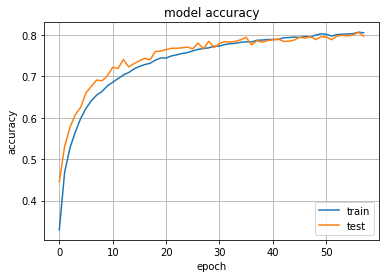

In [32]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid(True)
plt.show()

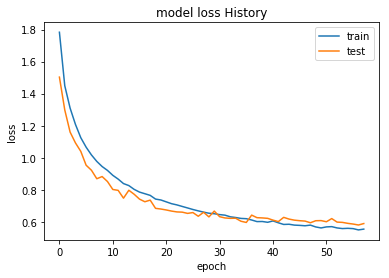

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

MODEL EVALUATION

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

MODEL PREDICTION

In [ ]:
predictions = model.predict(X_test)
predicted_labels=model.predict_classes(X_test)
#print([predictions[0],predicted_labels[0]])


#max= np.argmax(predictions[0])
#print(max)

#tt=y_test[0]
#print(tt)

# Plot the first 25 test images, their predicted label, and the true label
# Color correct predictions in green, incorrect predictions in red
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('False')
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    #plt.imshow(X_test[i], interpolation='nearest')
    predicted_label = np.argmax(predictions[i])
    true_label = y_test[i][0]
    if predicted_label == true_label:
      color = 'green'
    else:
      color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label], 
                                  class_names[true_label]),
                                  color=color)
plt.show()
plt.savefig("cifar10-lenet.pdf")

In [ ]:
print('Finish')

from PIL import Image
import numpy as np

w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()

from scipy.misc import toimage
toimage(data).show()

In [ ]:
#import keras
#vgg_model = keras.applications.vgg16.VGG16()
#model = keras.Sequential()
#model.add(vgg_model.layers[0])